In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline

In [2]:
fileName= "Occupancy_Estimation.csv"
df = pd.read_csv(fileName)
print(df.shape)
print(df.columns)

(10129, 19)
Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')


In [3]:
df.describe()

S1_Temp       S2_Temp       S3_Temp       S4_Temp      S1_Light  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      25.454012     25.546059     25.056621     25.754125     25.445059   
std        0.351351      0.586325      0.427283      0.356434     51.011264   
min       24.940000     24.750000     24.440000     24.940000      0.000000   
25%       25.190000     25.190000     24.690000     25.440000      0.000000   
50%       25.380000     25.380000     24.940000     25.750000      0.000000   
75%       25.630000     25.630000     25.380000     26.000000     12.000000   
max       26.380000     29.000000     26.190000     26.560000    165.000000   

          S2_Light      S3_Light      S4_Light      S1_Sound      S2_Sound  \
count  10129.00000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      26.01629     34.248494     13.220259      0.168178      0.120066   
std       67.30417     58.400744     19.602219      0.316709      0.266503   
min        0.00000      0.000000      0.000000      0.060000      0.040000   
25%        0.00000      0.000000      0.000000      0.070000      0.050000   
50%        0.00000      0.000000      0.000000      0.080000      0.050000   
75%       14.00000     50.000000     22.000000      0.080000      0.060000   
max      258.00000    280.000000     74.000000      3.880000      3.440000   

           S3_Sound      S4_Sound        S5_CO2  S5_CO2_Slope        S6_PIR  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean       0.158119      0.103840    460.860401     -0.004830      0.090137   
std        0.413637      0.120683    199.964940      1.164990      0.286392   
min        0.040000      0.050000    345.000000     -6.296154      0.000000   
25%        0.060000      0.060000    355.000000     -0.046154      0.000000   
50%        0.060000      0.080000    360.000000      0.000000      0.000000   
75%        0.070000      0.100000    465.000000      0.000000      0.000000   
max        3.670000      3.400000   1270.000000      8.980769      1.000000   

             S7_PIR  Room_Occupancy_Count  
count  10129.000000          10129.000000  
mean       0.079574              0.398559  
std        0.270645              0.893633  
min        0.000000              0.000000  
25%        0.000000              0.000000  
50%        0.000000              0.000000  
75%        0.000000              0.000000  
max        1.000000              3.000000

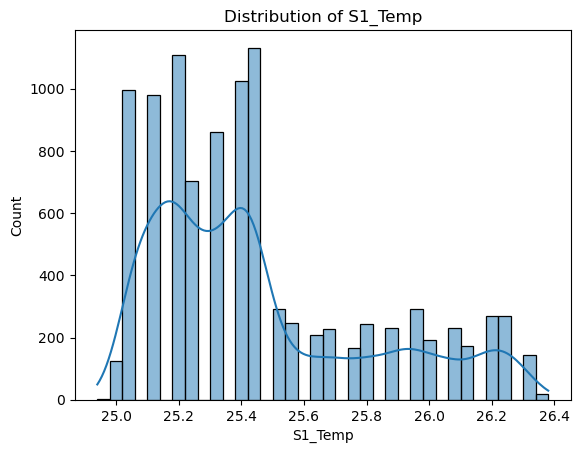

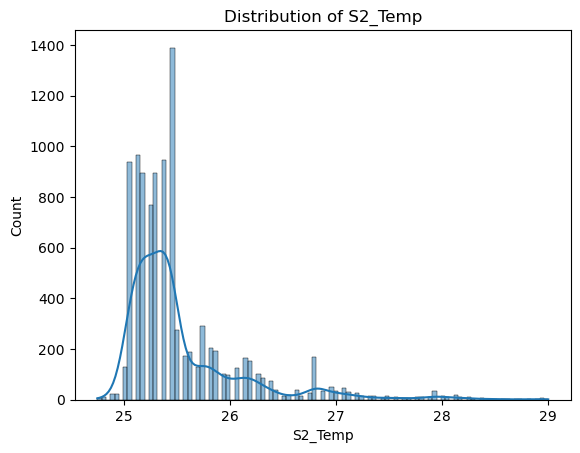

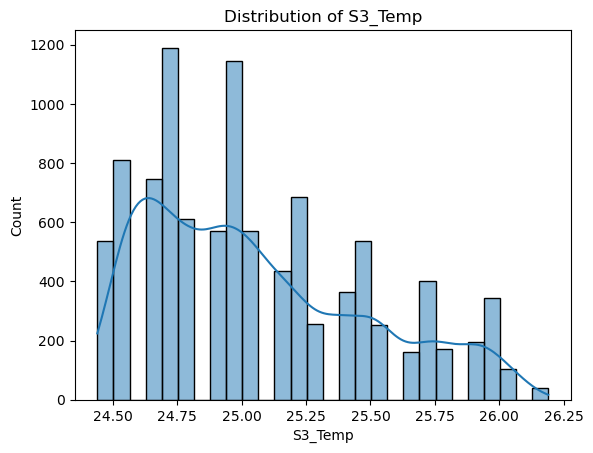

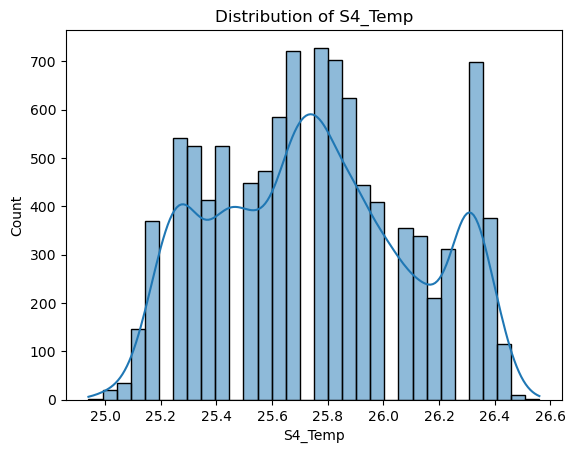

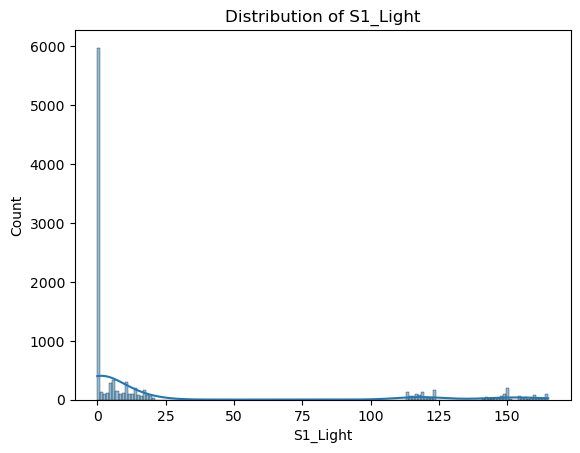

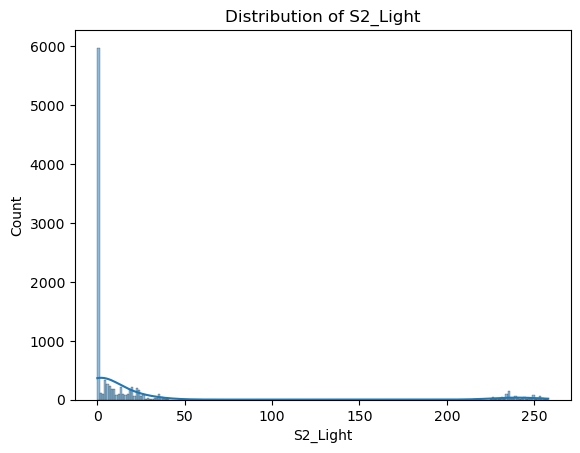

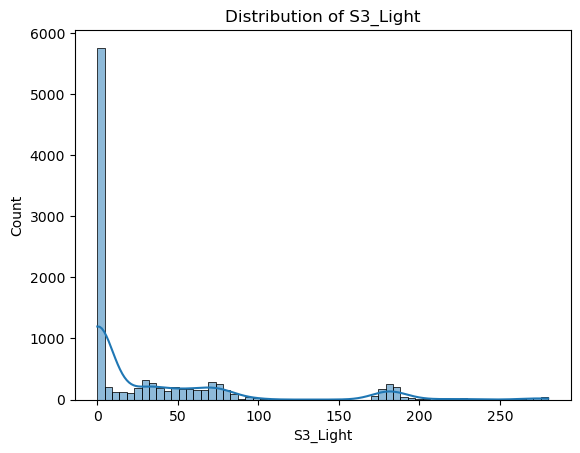

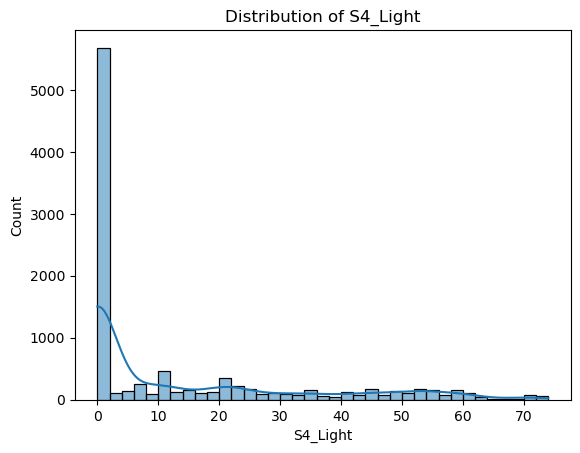

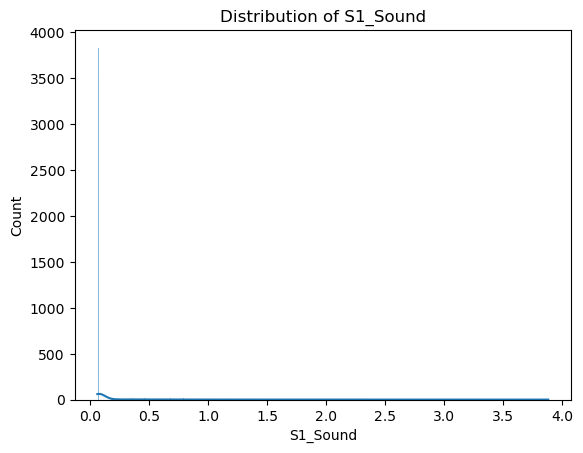

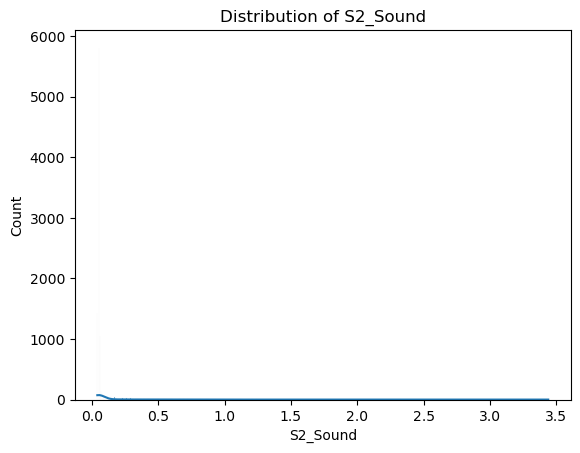

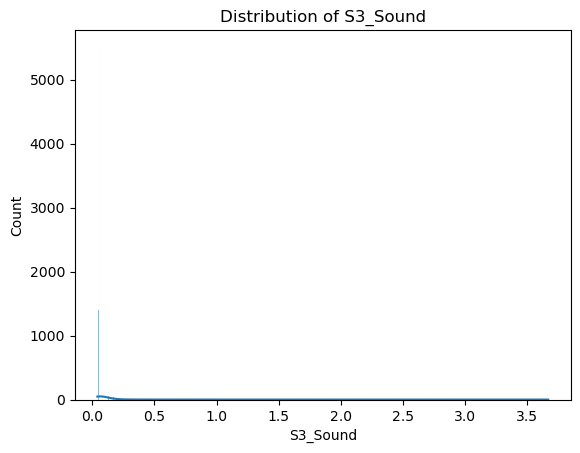

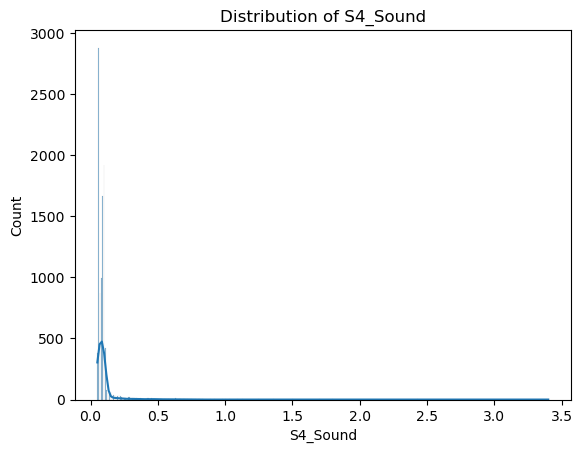

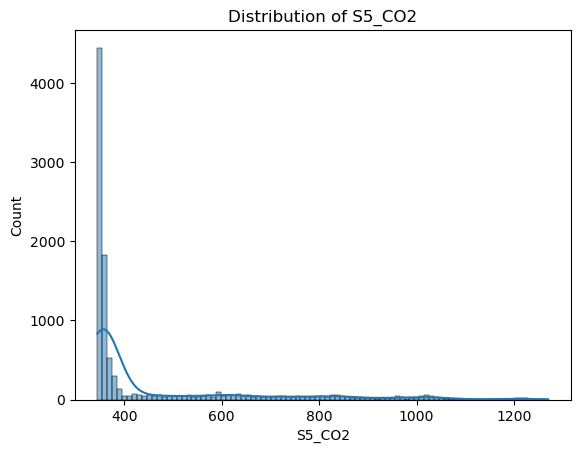

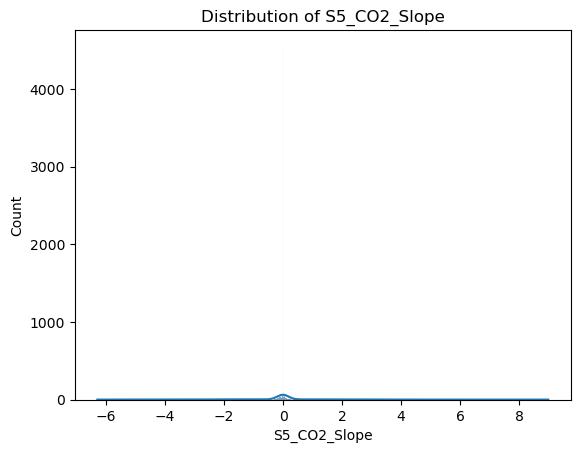

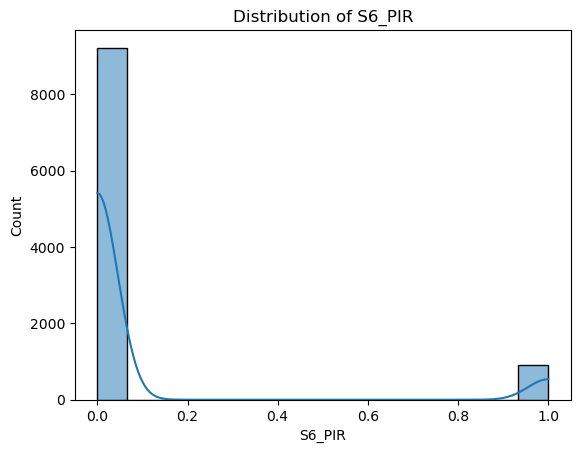

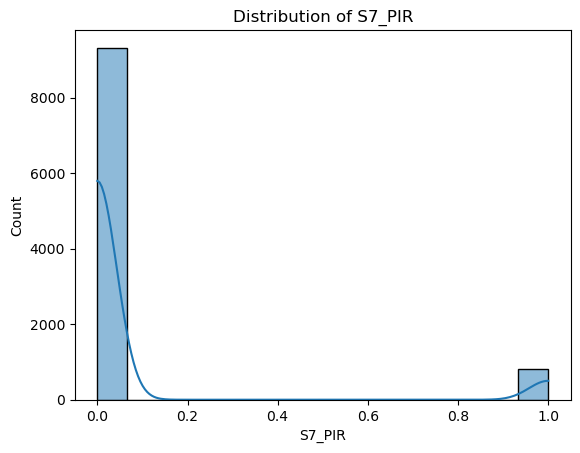

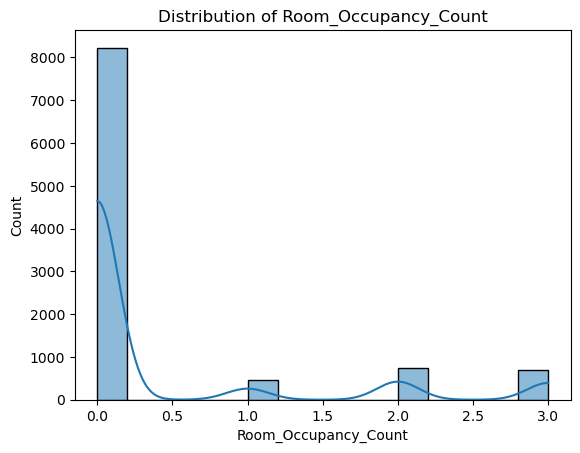

In [4]:
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure()
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

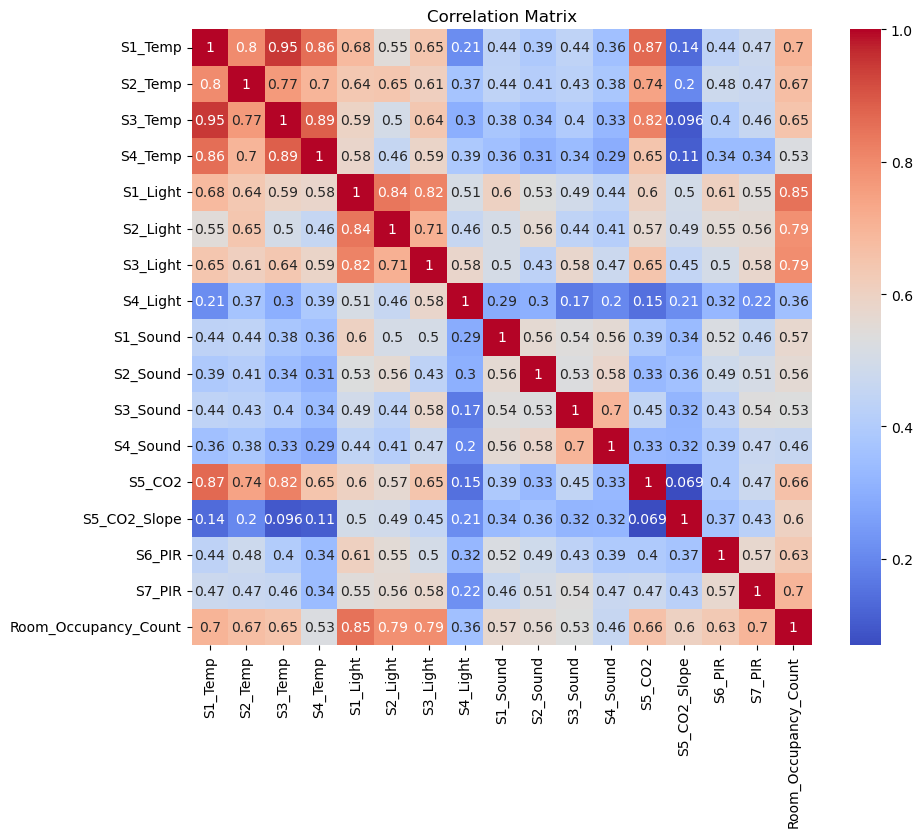

In [5]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

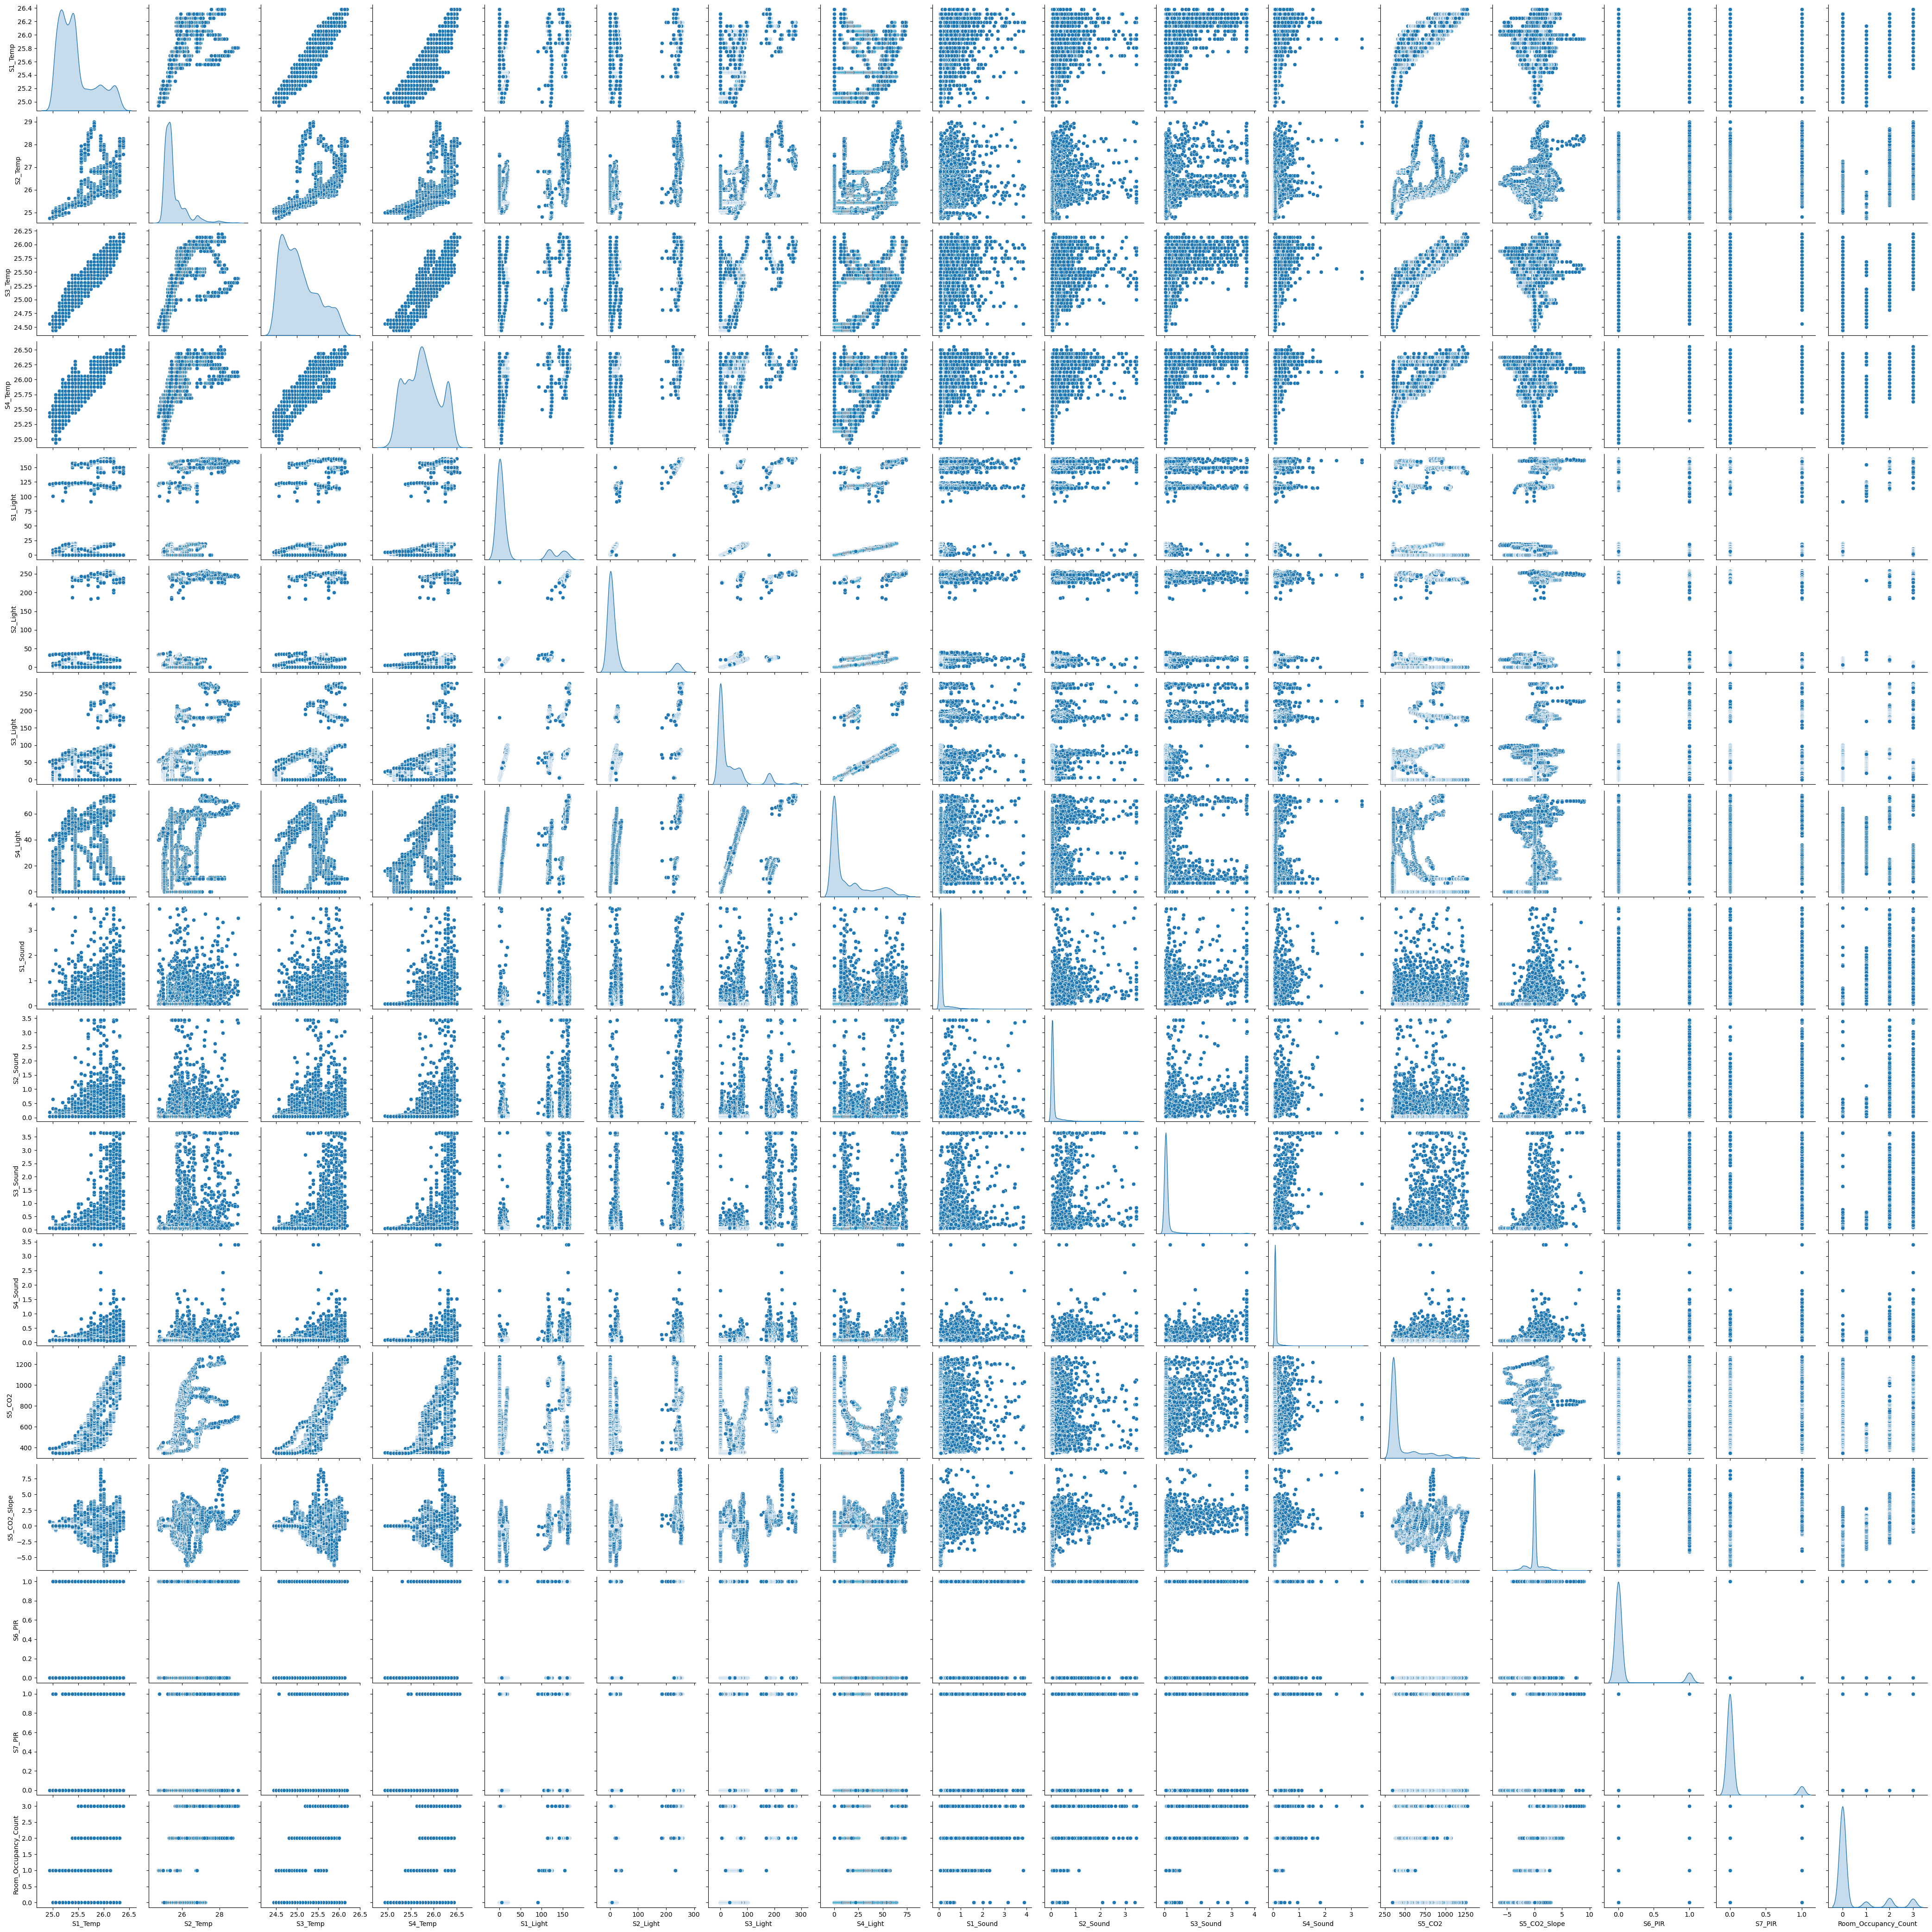

In [6]:
sns.pairplot(data= df, diag_kind='kde')

In [7]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

# Drop the original Date, Time, and DateTime columns
df.drop(['Date', 'Time', 'DateTime'], axis=1, inplace=True)

In [8]:
X = df.drop('Room_Occupancy_Count', axis=1)
y = df['Room_Occupancy_Count']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
models_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': [0.001, 0.01, 0.1],
            'kernel': ['rbf', 'poly']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 4],
            'min_samples_leaf': [1, 2]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 150],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(),
        'params': {
            'n_estimators': [100, 150],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    }
}


results = {}

In [12]:
for model_name, mp in models_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    
   
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

  
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'best_params': clf.best_params_
    }


for model_name, result in results.items():
    print(f"Model: {model_name}, Accuracy: {result['accuracy']}, Precision: {result['precision']}, "
          f"Recall: {result['recall']}, F1 Score: {result['f1_score']}, Best Parameters: {result['best_params']}")

Model: SVM, Accuracy: 0.9945705824284304, Precision: 0.9946065430512302, Recall: 0.9945705824284304, F1 Score: 0.9945866893969968, Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Model: RandomForest, Accuracy: 0.9985192497532083, Precision: 0.9985299785768691, Recall: 0.9985192497532083, F1 Score: 0.9985191414041705, Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Model: GradientBoosting, Accuracy: 0.9965449160908193, Precision: 0.9965369826938337, Recall: 0.9965449160908193, F1 Score: 0.9965236020013273, Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Model: XGBoost, Accuracy: 0.9975320829220138, Precision: 0.9975310399751005, Recall: 0.9975320829220138, F1 Score: 0.9975272951080547, Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
